# BERT Topic Modeling of PROMIS Smoking

Purpose: Employ BERT, a topic modeling algorithm, to automatically cluster text data into particular topics. In this particular example, I am analyzing the common topics/themes of 131 survey questions from surveys that measure smoking. 

Topic Modeling Information: https://maartengr.github.io/BERTopic/index.html

PROMIS Smoking Item Bank: https://www.rand.org/health-care/projects/promis-smoking-initiative/item-banks-short-forms.html

Citation: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4189408/

Inspiration: https://github.com/pinecone-io/examples/tree/master/learn/experimental/algos-and-libraries/bertopic

## How does BERTopic work?

**Data -> Sentence Embeddings** (transforming text into machine readable version - usually 768/384 dimensions)


Sentence Embeddings via Transformers Architecture
    Transformers use an encode/decode network. English into a context vector and then decoded. However the context vector is so complex this creates a bottleneck into the decoder. So the attention mechanism tells which decoder parts to focus on. In 2017, attention paper released that found they can remove the recurrent parts of the network and just keep the attention mechanism so high-performing. (called a transformer).

New attention (transformer): 
(1) have positional encoding (sense of order of the tokens)
(2) self-attention (how a word is applied to all other words in the sentence). Rather than embed the meaning of the individual word, it embeds the context of the words around it.
(3) multi-head attention (parallelization)

We can take a pre-trained core (e.g. BERT) and can fine-tune it.

So now we have a vector with 768/384 dimensions.

    
**Embeddings -> UMAP** (dimensionality reduction)

UMAP helps us compress embeddings into a smaller vector small (2 or 3 dimensions).
Understands density of particular areas in the data through k_nearest_neighbors. Understands distance between different vector rows


**UMAP -> clustering with HDBSCAN**
Here we can define the number of points needed to define a cluster. (by default something like 5)

(Number of topics can be determined by how we set parameters like min_cluster_size and min_samples (how dense the core of a cluster needs to be to group))

**clustering with HDBSCAN -> C-TF-IDF**
Looks at freq. of words with a particular cluster, and see how common these words are.


## Imports and Setup

In [1]:
from bertopic import BERTopic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%run Functions/Functions.ipynb

In [2]:
df = pd.read_csv('../Data/PROMIS_Smoking.csv')

# Put questions in a list
docs = df['Question Text'].to_list()

## Naive BERTopic (default hyperparameters)

In [ ]:
# Naive vectorizer to remove stop words
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_model = CountVectorizer(stop_words="english")
topic_model = BERTopic(vectorizer_model=vectorizer_model, nr_topics='auto')
# fit model
topics, probs = topic_model.fit_transform(docs)

In [ ]:
topic_info_df = topic_model.get_topic_info()
topic_info_df

In [ ]:
bar_chart = topic_model.visualize_barchart()

# Update filepath as needed
bar_chart.write_image("../Visualizations/BERTopic_Bar_Chart.png", width=800, height=600)
bar_chart

In [ ]:
# Visualize Topics
intertopic_map = topic_model.visualize_topics().show()
#heat_map = topic_model.visualize_heatmap()

# # Update filepath as needed to save
# heat_map.write_image("../Visualizations/BERTopic_Heat_Map.png", width=800, height=600)
# heat_map

## Investigate Factor Loadings of Original Factors vs. BERTopic

In [ ]:
### Get cluster assignments of BERTopic and then merge into dataset
full_BERTopic_info = topic_model.get_document_info(docs)

# Join the "Document" column of full_BERTopic_info with the "Question Text" column of df
merged_df = pd.merge(df, full_BERTopic_info, left_on="Question Text", right_on="Document", how="inner")

# Drop the duplicate "Document" column if needed
merged_df.drop("Document", axis=1, inplace=True)

merged_df_subset = merged_df[["Factor", "Question Text", "Topic", "Name"]]
# Rename columns for readability
merged_df_subset = merged_df_subset.rename(columns={
    "Question Text": "Document",
    "Factor": "Original Factor",
    "Topic": "BERTopic Topic",
    "Name": "BERTopic Name"
})

merged_df_subset = merged_df_subset[['Document', 'Original Factor', 'BERTopic Topic', 'BERTopic Name']]
merged_df_subset.head()

In [ ]:
# Create a cross-tabulation table to count the frequency of occurrences of each combination of "Original Factor" and "BERTopic Topic".
cross_tab = pd.crosstab(merged_df_subset["Original Factor"], merged_df_subset["BERTopic Topic"])

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, cmap="Blues", annot=True, fmt="d")
plt.title("Cross-Tabulation of Original Factors and BERTopic Topics")
plt.xlabel("BERTopic Topics")
plt.ylabel("Original Factors")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("../Visualizations/BERTopic_CrossTab.png")
plt.show()

In [ ]:
# Perform chi-squared test of independence to determine whether there is a stat. sig. assoc. 
# to see whether obs. freqs. in the contingency table differ significantly.
from scipy.stats import chi2_contingency

# Convert text values to categorical variables
merged_df_subset["Original Factor"] = pd.Categorical(merged_df_subset["Original Factor"])
merged_df_subset["BERTopic Topic"] = pd.Categorical(merged_df_subset["BERTopic Topic"])

# Create a contingency table
contingency_table = pd.crosstab(merged_df_subset["Original Factor"], merged_df_subset["BERTopic Topic"])

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-squared statistic:", chi2, "P-value:", p_value, "Degrees of freedom:", dof)

## Customizing BERTopic and Comparing Multiple Models

Inspiration: https://www.pinecone.io/learn/bertopic/

For information on the meaning of parameters, look up the Functions.ipynb file

Num Topics  Coherence (NPMI)  \
Model 0 (min cluster: 2, min sample: 1)          37.0               1.0   
Model 1 (min cluster: 3, min sample: 3)          12.0               1.0   
Model 2 (min cluster: 5, min sample: 5)           7.0               1.0   
Model 3 (min cluster: 10, min sample: 10)         2.0               1.0   
Model 4 (min cluster: 11, min sample: 1)          5.0               1.0   

                                           Silhouette Score       ARI  \
Model 0 (min cluster: 2, min sample: 1)            0.460272  0.107627   
Model 1 (min cluster: 3, min sample: 3)            0.462819  0.267357   
Model 2 (min cluster: 5, min sample: 5)            0.583853  0.203349   
Model 3 (min cluster: 10, min sample: 10)          0.366911  0.043114   
Model 4 (min cluster: 11, min sample: 1)           0.477141  0.172292   

                                             Purity       NMI  Precision  \
Model 0 (min cluster: 2, min sample: 1)    0.763359  0.486262   0.386641   
Model 1 (min cluster: 3, min sample: 3)    0.648855  0.425030   0.108587   
Model 2 (min cluster: 5, min sample: 5)    0.580153  0.405523   0.037132   
Model 3 (min cluster: 10, min sample: 10)  0.335878  0.150223   0.030844   
Model 4 (min cluster: 11, min sample: 1)   0.496183  0.293923   0.263706   

                                             Recall        F1  
Model 0 (min cluster: 2, min sample: 1)    0.114504  0.168851  
Model 1 (min cluster: 3, min sample: 3)    0.076336  0.087988  
Model 2 (min cluster: 5, min sample: 5)    0.061069  0.045628  
Model 3 (min cluster: 10, min sample: 10)  0.091603  0.046108  
Model 4 (min cluster: 11, min sample: 1)   0.244275  0.250561

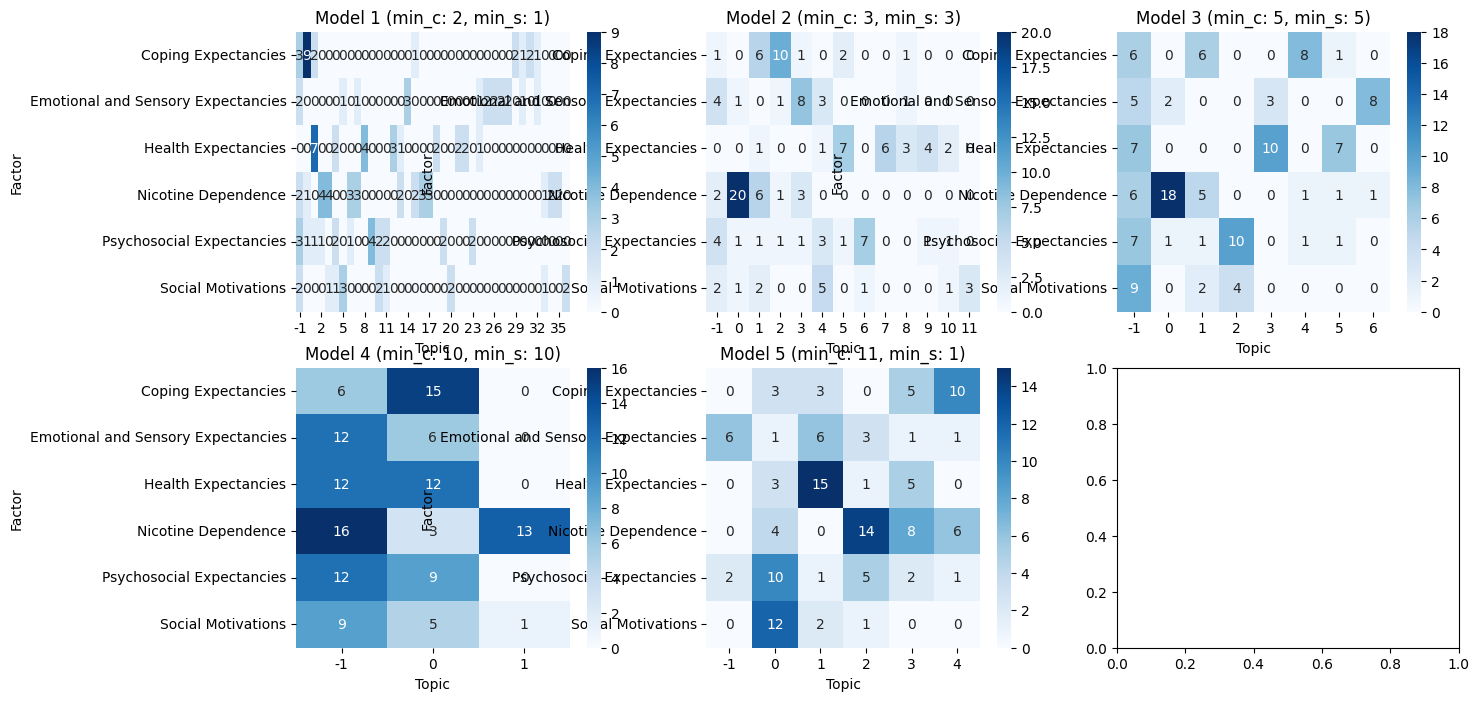

In [108]:
%run Functions/Functions.ipynb

def get_model_comparisons(models):
    # Create an empty DataFrame
    comparison_df = pd.DataFrame(columns=['Num Topics', 'Coherence (NPMI)', 'Silhouette Score', 'ARI', 'Purity', 'NMI', 'Precision', 'Recall', 'F1'])
        
    # Most popular model - Hugging Face: https://huggingface.co/sentence-transformers?sort_models=downloads#models
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
    
    # remove stopwords/stop phrases containing 1 and 2 words
    # ngram_range is another potential parameter: ngram_range=(1, 2)
    vectorizer_model = CountVectorizer(stop_words="english")

    # Information for Cross-Tab Visualizations
    n_plots = len(models)
    n_rows = 2
    n_cols = n_plots // n_rows + (n_plots % n_rows > 0)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 8))
    axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]


    for index, mod in enumerate(models):
        ### Run custom model
        model = run_custom_BERTopic(docs, embedding_model, vectorizer_model, min_cluster_size=mod['min_cluster_size'], min_samples=mod['min_samples'], n_neighbors=mod['n_neighbors'])
        topics, probs = model.fit_transform(docs)
        
        topic_info_df = model.get_topic_info()
        
        num_topics = len(topic_info_df) - 1 # DOES NOT INCLUDE OUTLIERS TOPIC. ONLY COHERENT TOPICS
        

        ### Gather evaluation metrics
        coh = coherence_score(docs, model, vectorizer_model)
        
        # play with seeing if you actually need topics param here
        sil = silhouette_metric(docs, embedding_model, model, topics)
        
        true_values = df['Factor']
        predicted_values = model.get_document_info(docs)['Topic'] # NOTE THAT TOPIC -1 is included in the predicted_labels. Need to handle?!?!?!
        
        ari, purity, nmi = evaluation_metrics(true_values, predicted_values)
        precision, recall, f1 = f1score(true_values, predicted_values)
        
        comparison_df.loc["Model " + str(index) + " (min cluster: " + str(mod['min_cluster_size']) + ", min sample: " + str(mod['min_samples']) + ")"] = [
            num_topics, coh, sil, ari, purity, nmi, precision, recall, f1]

        ### Generate visualizations
        cross_tab = pd.crosstab(true_values, predicted_values)

        # Heatmap
        sns.heatmap(cross_tab, cmap="Blues", annot=True, fmt="d", ax=axs[index])
        axs[index].set_title(f"Model {index+1} (min_c: {mod['min_cluster_size']}, min_s: {mod['min_samples']})")
    
    # plt.tight_layout()
    # plt.show()
    return comparison_df



# List of models as dictionaries
models = [
    {"min_cluster_size": 2, "min_samples": 1, "n_neighbors": 15},
    {"min_cluster_size": 3, "min_samples": 3, "n_neighbors": 15},
    {"min_cluster_size": 5, "min_samples": 5, "n_neighbors": 15}, # I think this is default params for hdbscan, so other parameters are different
    {"min_cluster_size": 10, "min_samples": 10, "n_neighbors": 15},
    {"min_cluster_size": 11, "min_samples": 1, "n_neighbors": 2},
]

res = get_model_comparisons(models)
res

## Summarative Search

In [102]:
%run Functions/Functions.ipynb
from concurrent.futures import ThreadPoolExecutor

def get_model_comparisons(mod):
    # Create an empty DataFrame
    comparison_df = pd.DataFrame(columns=['Num Topics', 'Silhouette Score', 'ARI', 'Purity', 'NMI', 'Precision', 'Recall', 'F1'])
        
    # Most popular model - Hugging Face: https://huggingface.co/sentence-transformers?sort_models=downloads#models
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
    
    # remove stopwords/stop phrases containing 1 and 2 words
    # ngram_range is another potential parameter: ngram_range=(1, 2)
    vectorizer_model = CountVectorizer(stop_words="english")

    print(mod)
    ### Run custom model
    model = run_custom_BERTopic(docs, embedding_model, vectorizer_model, min_cluster_size=mod['min_cluster_size'], min_samples=mod['min_samples'], n_neighbors=mod['n_neighbors'])
    topics, probs = model.fit_transform(docs)
        
    topic_info_df = model.get_topic_info()
    num_topics = len(topic_info_df) - 1 # DOES NOT INCLUDE OUTLIERS TOPIC. ONLY COHERENT TOPICS
        
    
    # play with seeing if you actually need topics param here
    sil = silhouette_metric(docs, embedding_model, model, topics)
        
    true_values = df['Factor']
    predicted_values = model.get_document_info(docs)['Topic'] # NOTE THAT TOPIC -1 is included in the predicted_labels. Need to handle?!?!?!
        
    ari, purity, nmi = evaluation_metrics(true_values, predicted_values)
    precision, recall, f1 = f1score(true_values, predicted_values)
    
    comparison_df.loc[" (min cluster: " + str(mod['min_cluster_size']) + ", min sample: " + str(mod['min_samples']) + ", n_neighbors: " + str(mod['n_neighbors']) +")"] = [
        num_topics, sil, ari, purity, nmi, precision, recall, f1]

    return comparison_df


# List of models to evaluate
models = [{"min_cluster_size": x, "min_samples": y, "n_neighbors": z} 
          # why up to 15? Factor with lowest questions has 15.
          for x in range(2, 15, 3)  
          for y in range(1, 15, 3)   
          for z in range(2, 22, 3)   
          if y <= x
         ]

# Number of parallel threads
num_threads = 4  # Adjust based on your system's capabilities

# Create a pool of threads and compute squares in parallel
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    results = executor.map(get_model_comparisons, models)

print("Done!")

{'min_cluster_size': 2, 'min_samples': 1, 'n_neighbors': 8}
{'min_cluster_size': 2, 'min_samples': 1, 'n_neighbors': 11}
{'min_cluster_size': 2, 'min_samples': 1, 'n_neighbors': 5}
{'min_cluster_size': 2, 'min_samples': 1, 'n_neighbors': 2}
{'min_cluster_size': 2, 'min_samples': 1, 'n_neighbors': 14}
{'min_cluster_size': 2, 'min_samples': 1, 'n_neighbors': 17}
{'min_cluster_size': 2, 'min_samples': 1, 'n_neighbors': 20}
{'min_cluster_size': 5, 'min_samples': 1, 'n_neighbors': 2}
{'min_cluster_size': 5, 'min_samples': 1, 'n_neighbors': 5}
{'min_cluster_size': 5, 'min_samples': 1, 'n_neighbors': 8}
{'min_cluster_size': 5, 'min_samples': 1, 'n_neighbors': 11}
{'min_cluster_size': 5, 'min_samples': 1, 'n_neighbors': 14}
{'min_cluster_size': 5, 'min_samples': 1, 'n_neighbors': 17}
{'min_cluster_size': 5, 'min_samples': 1, 'n_neighbors': 20}
{'min_cluster_size': 5, 'min_samples': 4, 'n_neighbors': 2}
{'min_cluster_size': 5, 'min_samples': 4, 'n_neighbors': 5}
{'min_cluster_size': 5, 'min_sam

In [103]:
# Concatenate all the individual comparison_df DataFrames into one large DataFrame
final_df = pd.concat(results, axis=0)
ex_df = final_df
ex_df

Num Topics  \
 (min cluster: 2, min sample: 1, n_neighbors: 2)          46.0   
 (min cluster: 2, min sample: 1, n_neighbors: 5)          44.0   
 (min cluster: 2, min sample: 1, n_neighbors: 8)          40.0   
 (min cluster: 2, min sample: 1, n_neighbors: 11)         35.0   
 (min cluster: 2, min sample: 1, n_neighbors: 14)         43.0   
...                                                        ...   
 (min cluster: 14, min sample: 13, n_neighbors: 8)         3.0   
 (min cluster: 14, min sample: 13, n_neighbors:...         0.0   
 (min cluster: 14, min sample: 13, n_neighbors:...         2.0   
 (min cluster: 14, min sample: 13, n_neighbors:...         2.0   
 (min cluster: 14, min sample: 13, n_neighbors:...         2.0   

                                                   Silhouette Score       ARI  \
 (min cluster: 2, min sample: 1, n_neighbors: 2)           0.842841  0.083199   
 (min cluster: 2, min sample: 1, n_neighbors: 5)            0.59505  0.072269   
 (min cluster: 2, min sample: 1, n_neighbors: 8)           0.511275  0.093169   
 (min cluster: 2, min sample: 1, n_neighbors: 11)          0.485565  0.103477   
 (min cluster: 2, min sample: 1, n_neighbors: 14)           0.51561  0.062655   
...                                                             ...       ...   
 (min cluster: 14, min sample: 13, n_neighbors: 8)         0.572325  0.125171   
 (min cluster: 14, min sample: 13, n_neighbors:...         0 topics  0.000000   
 (min cluster: 14, min sample: 13, n_neighbors:...         0.394823  0.040305   
 (min cluster: 14, min sample: 13, n_neighbors:...         0.402049  0.071074   
 (min cluster: 14, min sample: 13, n_neighbors:...         0.401016  0.017159   

                                                      Purity       NMI  \
 (min cluster: 2, min sample: 1, n_neighbors: 2)    0.786260  0.512609   
 (min cluster: 2, min sample: 1, n_neighbors: 5)    0.770992  0.490079   
 (min cluster: 2, min sample: 1, n_neighbors: 8)    0.770992  0.491963   
 (min cluster: 2, min sample: 1, n_neighbors: 11)   0.748092  0.485852   
 (min cluster: 2, min sample: 1, n_neighbors: 14)   0.732824  0.462539   
...                                                      ...       ...   
 (min cluster: 14, min sample: 13, n_neighbors: 8)  0.442748  0.294748   
 (min cluster: 14, min sample: 13, n_neighbors:...  0.244275  0.000000   
 (min cluster: 14, min sample: 13, n_neighbors:...  0.335878  0.142074   
 (min cluster: 14, min sample: 13, n_neighbors:...  0.351145  0.165083   
 (min cluster: 14, min sample: 13, n_neighbors:...  0.312977  0.118363   

                                                    Precision    Recall  \
 (min cluster: 2, min sample: 1, n_neighbors: 2)     0.000000  0.000000   
 (min cluster: 2, min sample: 1, n_neighbors: 5)     0.008437  0.007634   
 (min cluster: 2, min sample: 1, n_neighbors: 8)     0.044275  0.022901   
 (min cluster: 2, min sample: 1, n_neighbors: 11)    0.028289  0.022901   
 (min cluster: 2, min sample: 1, n_neighbors: 14)    0.233588  0.068702   
...                                                       ...       ...   
 (min cluster: 14, min sample: 13, n_neighbors: 8)   0.073697  0.106870   
 (min cluster: 14, min sample: 13, n_neighbors:...   0.025698  0.160305   
 (min cluster: 14, min sample: 13, n_neighbors:...   0.058503  0.183206   
 (min cluster: 14, min sample: 13, n_neighbors:...   0.052573  0.160305   
 (min cluster: 14, min sample: 13, n_neighbors:...   0.052569  0.152672   

                                                          F1  
 (min cluster: 2, min sample: 1, n_neighbors: 2)    0.000000  
 (min cluster: 2, min sample: 1, n_neighbors: 5)    0.008015  
 (min cluster: 2, min sample: 1, n_neighbors: 8)    0.029262  
 (min cluster: 2, min sample: 1, n_neighbors: 11)   0.025311  
 (min cluster: 2, min sample: 1, n_neighbors: 14)   0.090984  
...                                                      ...  
 (min cluster: 14, min sample: 13, n_neighbors: 8)  0.0

In [116]:
# (1) Descriptive statistics for "Num Topics" column
num_topics_stats = ex_df["Num Topics"].describe()

# (2) Top 5 rows with highest "Silhouette Score"
# top_5_silhouette_score_rows = ex_df.sort_values(by="Silhouette Score", ascending=False).head(5)
top_5_ari_rows = ex_df.sort_values(by="ARI", ascending=False).head(5)
top_5_purity_rows = ex_df.sort_values(by="Purity", ascending=False).head(5)
top_5_nmi_rows = ex_df.sort_values(by="NMI", ascending=False).head(5)
top_5_precision_rows = ex_df.sort_values(by="Precision", ascending=False).head(5)
top_5_recall_rows = ex_df.sort_values(by="Recall", ascending=False).head(5)
top_5_f1_rows = ex_df.sort_values(by="F1", ascending=False).head(5)

num_topics_stats
top_5_f1_rows

Num Topics  \
 (min cluster: 11, min sample: 1, n_neighbors: 2)          6.0   
 (min cluster: 8, min sample: 1, n_neighbors: 20)          8.0   
 (min cluster: 14, min sample: 1, n_neighbors: 5)          4.0   
 (min cluster: 11, min sample: 7, n_neighbors: 14)         3.0   
 (min cluster: 14, min sample: 1, n_neighbors: 20)         4.0   

                                                   Silhouette Score       ARI  \
 (min cluster: 11, min sample: 1, n_neighbors: 2)          0.627845  0.167917   
 (min cluster: 8, min sample: 1, n_neighbors: 20)           0.41291  0.257497   
 (min cluster: 14, min sample: 1, n_neighbors: 5)          0.400274  0.257022   
 (min cluster: 11, min sample: 7, n_neighbors: 14)          0.52355  0.148391   
 (min cluster: 14, min sample: 1, n_neighbors: 20)         0.393044  0.231370   

                                                      Purity       NMI  \
 (min cluster: 11, min sample: 1, n_neighbors: 2)   0.503817  0.292219   
 (min cluster: 8, min sample: 1, n_neighbors: 20)   0.633588  0.452565   
 (min cluster: 14, min sample: 1, n_neighbors: 5)   0.496183  0.354471   
 (min cluster: 11, min sample: 7, n_neighbors: 14)  0.450382  0.293583   
 (min cluster: 14, min sample: 1, n_neighbors: 20)  0.496183  0.335326   

                                                    Precision    Recall  \
 (min cluster: 11, min sample: 1, n_neighbors: 2)    0.372246  0.282443   
 (min cluster: 8, min sample: 1, n_neighbors: 20)    0.369406  0.267176   
 (min cluster: 14, min sample: 1, n_neighbors: 5)    0.313020  0.251908   
 (min cluster: 11, min sample: 7, n_neighbors: 14)   0.280394  0.274809   
 (min cluster: 14, min sample: 1, n_neighbors: 20)   0.235187  0.229008   

                                                          F1  
 (min cluster: 11, min sample: 1, n_neighbors: 2)   0.317840  
 (min cluster: 8, min sample: 1, n_neighbors: 20)   0.295330  
 (min cluster: 14, min sample: 1, n_neighbors: 5)   0.263881  
 (min cluster: 11, min sample: 7, n_neighbors: 14)  0.249550  
 (min cluster: 14, min sample: 1, n_neighbors: 20)  0.225808

## Subsets of Items

### ALL/D/ND questions

In [157]:
# What happens if we subset our data only on the ALL/D/ND questions?

In [158]:
all_smoke_df = df[df["Applicable Population"] == "ALL/D/ND"]

print(all_smoke_df.shape)
# Put questions in a list
all_smoke_docs = all_smoke_df['Question Text'].to_list()

(81, 6)


In [168]:
# Most popular model - Hugging Face: https://huggingface.co/sentence-transformers?sort_models=downloads#models
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# remove stopwords/stop phrases containing 1 and 2 words
# NGRAM_RANGE is an important choice
stop_words = list(stopwords.words('english'))
vectorizer_model = CountVectorizer(ngram_range = (1,3), stop_words=stop_words)


# Run custom model
model = run_custom_BERTopic(all_smoke_docs, embedding_model, vectorizer_model, min_cluster_size=5, min_samples=5)
topics, probs = model.fit_transform(all_smoke_docs)

topic_info_df = model.get_topic_info()

num_topics = len(topic_info_df) - 1 # DOES NOT INCLUDE OUTLIERS TOPIC. ONLY COHERENT TOPICS

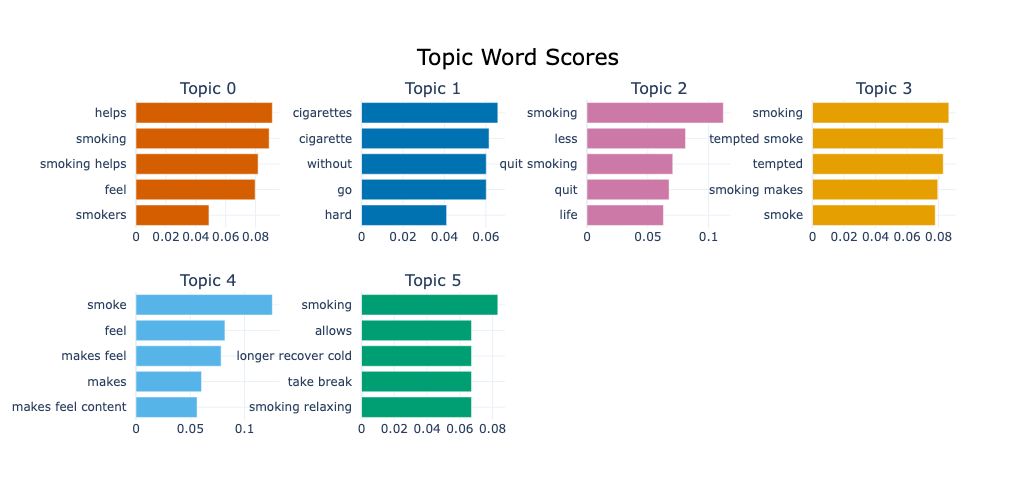

In [169]:
bar_chart = model.visualize_barchart()

# Update filepath as needed
bar_chart.write_image("../Visualizations/BERTopic_Bar_Chart.png", width=800, height=600)
bar_chart

In [170]:
### Get cluster assignments of BERTopic and then merge into dataset
full_BERTopic_info = model.get_document_info(all_smoke_docs)

# Join the "Document" column of full_BERTopic_info with the "Question Text" column of df
merged_df = pd.merge(all_smoke_df, full_BERTopic_info, left_on="Question Text", right_on="Document", how="inner")

# Drop the duplicate "Document" column if needed
merged_df.drop("Document", axis=1, inplace=True)

merged_df_subset = merged_df[["Factor", "Question Text", "Topic", "Name"]]
# Rename columns for readability
merged_df_subset = merged_df_subset.rename(columns={
    "Question Text": "Document",
    "Factor": "Original Factor",
    "Topic": "BERTopic Topic",
    "Name": "BERTopic Name"
})

merged_df_subset = merged_df_subset[['Document', 'Original Factor', 'BERTopic Topic', 'BERTopic Name']]

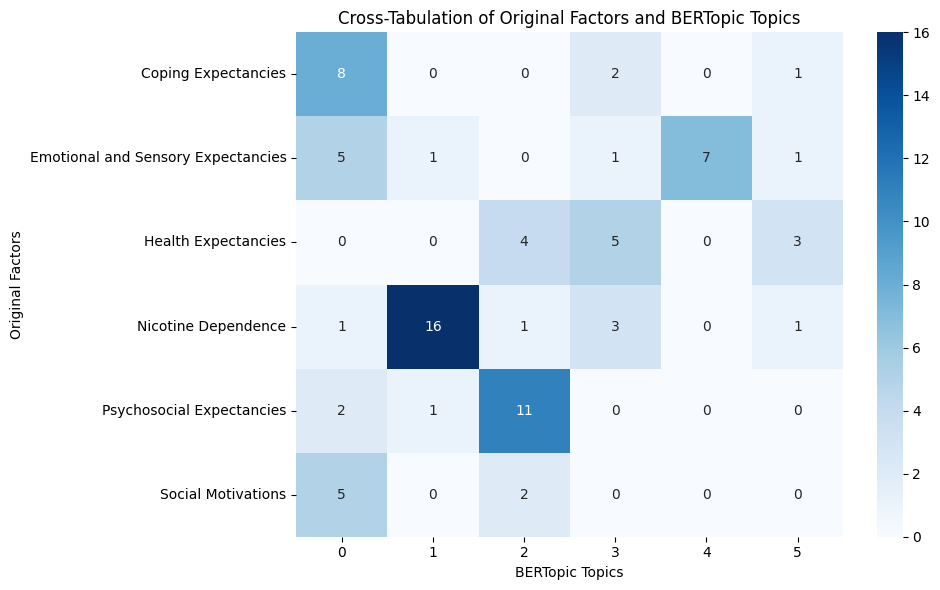

In [171]:
# Create a cross-tabulation table to count the frequency of occurrences of each combination of "Original Factor" and "BERTopic Topic".
cross_tab = pd.crosstab(merged_df_subset["Original Factor"], merged_df_subset["BERTopic Topic"])

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, cmap="Blues", annot=True, fmt="d")
plt.title("Cross-Tabulation of Original Factors and BERTopic Topics")
plt.xlabel("BERTopic Topics")
plt.ylabel("Original Factors")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("../Visualizations/BERTopic_CrossTab.png")
plt.show()

### Q-type questions

In [174]:
q_type_df = df[df["Scale"] == "Q"]

print(q_type_df.shape)
# Put questions in a list
q_type_docs = q_type_df['Question Text'].to_list()

(99, 6)


In [175]:
# Most popular model - Hugging Face: https://huggingface.co/sentence-transformers?sort_models=downloads#models
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# remove stopwords/stop phrases containing 1 and 2 words
# NGRAM_RANGE is an important choice
stop_words = list(stopwords.words('english'))
vectorizer_model = CountVectorizer(ngram_range = (1,3), stop_words=stop_words)


# Run custom model
model = run_custom_BERTopic(q_type_docs, embedding_model, vectorizer_model, min_cluster_size=5, min_samples=5)
topics, probs = model.fit_transform(q_type_docs)

topic_info_df = model.get_topic_info()

num_topics = len(topic_info_df) - 1 # DOES NOT INCLUDE OUTLIERS TOPIC. ONLY COHERENT TOPICS

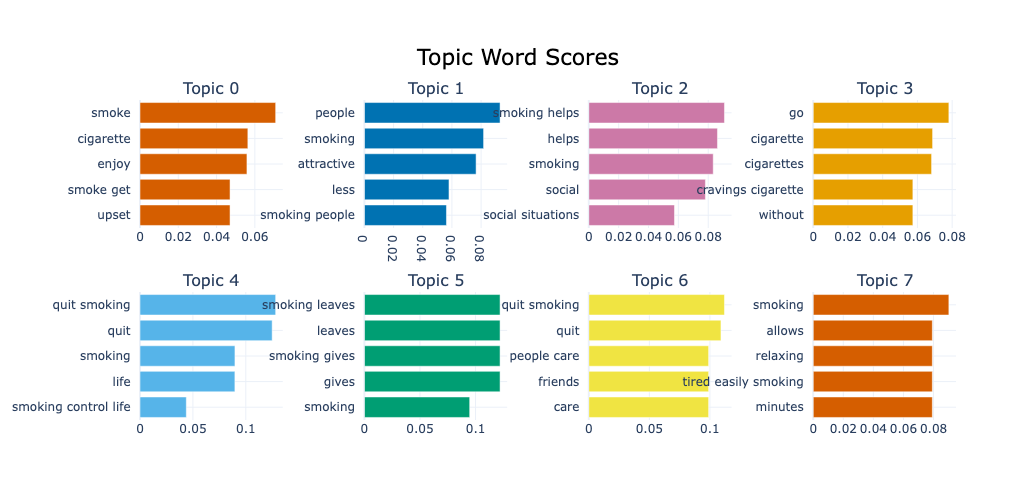

In [176]:
bar_chart = model.visualize_barchart()

# Update filepath as needed
bar_chart.write_image("../Visualizations/BERTopic_Bar_Chart.png", width=800, height=600)
bar_chart

In [177]:
### Get cluster assignments of BERTopic and then merge into dataset
full_BERTopic_info = model.get_document_info(q_type_docs)

# Join the "Document" column of full_BERTopic_info with the "Question Text" column of df
merged_df = pd.merge(q_type_df, full_BERTopic_info, left_on="Question Text", right_on="Document", how="inner")

# Drop the duplicate "Document" column if needed
merged_df.drop("Document", axis=1, inplace=True)

merged_df_subset = merged_df[["Factor", "Question Text", "Topic", "Name"]]
# Rename columns for readability
merged_df_subset = merged_df_subset.rename(columns={
    "Question Text": "Document",
    "Factor": "Original Factor",
    "Topic": "BERTopic Topic",
    "Name": "BERTopic Name"
})

merged_df_subset = merged_df_subset[['Document', 'Original Factor', 'BERTopic Topic', 'BERTopic Name']]

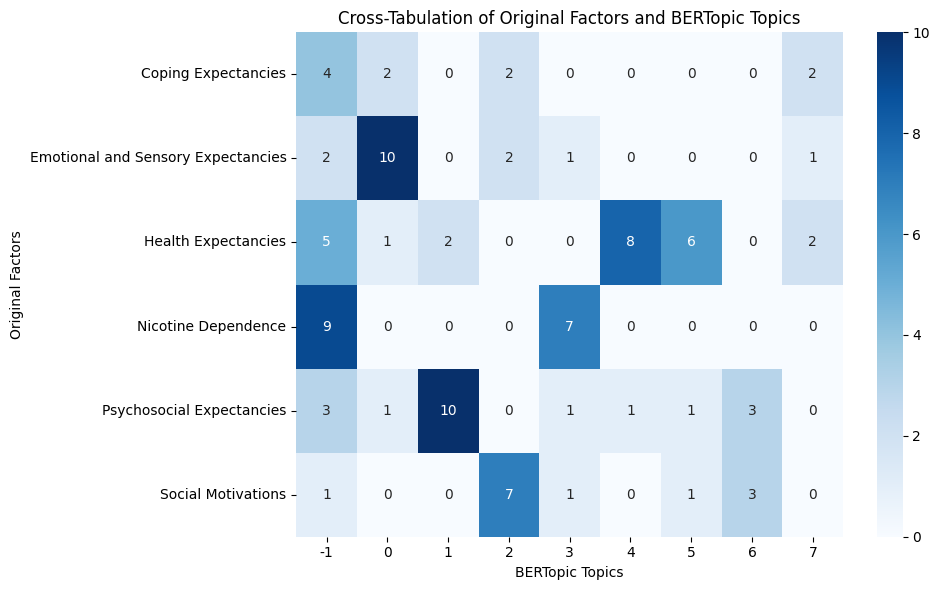

In [178]:
# Create a cross-tabulation table to count the frequency of occurrences of each combination of "Original Factor" and "BERTopic Topic".
cross_tab = pd.crosstab(merged_df_subset["Original Factor"], merged_df_subset["BERTopic Topic"])

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, cmap="Blues", annot=True, fmt="d")
plt.title("Cross-Tabulation of Original Factors and BERTopic Topics")
plt.xlabel("BERTopic Topics")
plt.ylabel("Original Factors")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("../Visualizations/BERTopic_CrossTab.png")
plt.show()

In [179]:
# Finding - this survey contains nuanced language?